Using device: cuda


/tmp/ipykernel_6840/1103264782.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


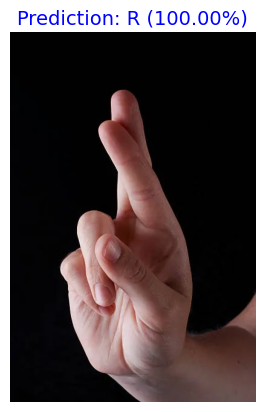

In [19]:
# Image Detection

import os
from PIL import Image
import torch
from torchvision import transforms
from torchvision.models import MobileNet_V2_Weights, mobilenet_v2
import matplotlib.pyplot as plt

# Global Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Transformation for Inputs
img_size = 224
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load Model Function
def load_model(model_path, num_classes):
    model = mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V1)
    model.classifier[1] = torch.nn.Linear(model.last_channel, num_classes)
    
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint, strict=False)  # Skip mismatched layers
    model = model.to(device).eval()
    return model

# Image Prediction
def predict_image(image_path, model, class_names):
    image = Image.open(image_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        probabilities = torch.nn.functional.softmax(output, dim=1)[0]
        confidence, predicted = torch.max(probabilities, 0)

    predicted_label = class_names[predicted.item()]
    return predicted_label, confidence.item()

# Display Image with Prediction
def display_prediction(image_path, label, confidence):
    image = Image.open(image_path).convert("RGB")
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Prediction: {label} ({confidence*100:.2f}%)", fontsize=14, color="blue")
    plt.show()

# Main Execution for Image Detection
if __name__ == "__main__":
    # Paths to the saved model and dataset
    image_model_path = "/home/mostafabakr/Desktop/Project X/modelsasl_image_model.pth"
    test_image_path = "/home/mostafabakr/Desktop/Project X/Test_img/sign-language-letter-r.webp"

    # Class Names
    image_class_names = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y']
    num_image_classes = len(image_class_names)

    # Load Image Model
    image_model = load_model(image_model_path, num_image_classes)

    # Single Image Prediction
    predicted_label, confidence = predict_image(test_image_path, image_model, image_class_names)

    # Display Prediction
    display_prediction(test_image_path, predicted_label, confidence)


In [18]:
# Video Detection

import os
import cv2
from PIL import Image
import torch
from torchvision import transforms
from torchvision.models import MobileNet_V2_Weights, mobilenet_v2

# Global Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Transformation for Inputs
img_size = 224
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load Model Function
def load_model(model_path, num_classes):
    model = mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V1)
    model.classifier[1] = torch.nn.Linear(model.last_channel, num_classes)
    
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint, strict=False)  # Skip mismatched layers
    model = model.to(device)
    model.eval()
    return model

# Video Prediction
def predict_video(video_path, model, class_names, frame_rate=5):
    cap = cv2.VideoCapture(video_path)
    predictions = []
    frame_count = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        if frame_count % frame_rate == 0:
            image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            input_tensor = transform(image).unsqueeze(0).to(device)

            with torch.no_grad():
                output = model(input_tensor)
                _, predicted = torch.max(output, 1)
                predictions.append(class_names[predicted.item()])

        frame_count += 1

    cap.release()

    # Majority voting for final prediction
    final_prediction = max(set(predictions), key=predictions.count)
    return final_prediction

# Main Execution for Video Detection
if __name__ == "__main__":
    # Paths to the saved model and test video
    video_model_path = "/home/mostafabakr/Desktop/Project X/modelsasl_video_model.pth"
    video_path = "/home/mostafabakr/Desktop/Project X/Test_img/Screencast from 11-29-2024 04:04:33 AM.webm"

    # Video Class Names
    video_class_names = ['J', 'Z']
    num_video_classes = len(video_class_names)

    # Load Video Model
    video_model = load_model(video_model_path, num_video_classes)

    # Video Prediction
    video_prediction = predict_video(video_path, video_model, video_class_names)
    print(f"Prediction for the video: {video_prediction}")

Using device: cuda


/tmp/ipykernel_6840/4217911403.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


Prediction for the video: J
